## Système de Recommandation de Contenus avec SARSA

### 🧠 Objectif du projet :
Construire un système de recommandation intelligent qui apprend à proposer les contenus les plus pertinents aux utilisateurs en analysant leurs interactions (clics, temps passé, etc.) sur une plateforme en ligne. Le système utilise l’algorithme SARSA (State-Action-Reward-State-Action) de Reinforcement Learning pour apprendre une politique de recommandation optimisée.



#### Labraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


#### Load data

In [3]:
df = pd.read_csv("data/merged_movie_data.csv",sep=';')

In [4]:
df.sample(10)


,userId,movieId,rating,timestamp,title,genres
3459,21,58998,4.5,1441393230,Forgetting Sarah Marshall (2008),Comedy|Romance
61442,405,1214,4.0,1300134613,Alien (1979),Horror|Sci-Fi
28742,199,2112,2.0,940372513,Grand Canyon (1991),Crime|Drama
17701,111,93270,1.5,1516152647,Project X (2012),Comedy
84703,546,3939,5.0,973588747,Slumber Party Massacre II (1987),Horror
90420,587,3471,4.0,953137197,Close Encounters of the Third Kind (1977),Adventure|Drama|Sci-Fi
13095,84,94,4.0,857653422,Beautiful Girls (1996),Comedy|Drama|Romance
62925,414,1863,2.0,961437759,Major League: Back to the Minors (1998),Comedy
49476,318,55247,4.5,1424546853,Into the Wild (2007),Action|Adventure|Drama
58735,382,45720,4.5,1515160931,"Devil Wears Prada, The (2006)",Comedy|Drama


#### Réindexation


**=> userId pour les lignes de Q-Table**

**=> movieId pour les lignes de Q-Table**

**=> idx_to_movie lorsqu'on extrait argmax(Q["state"]) pour traduire l’index en vrai movieId**

In [5]:
user_to_idx = {uid: idx for idx, uid in enumerate(sorted(df['userId'].unique()))}
movie_to_idx = {mid: idx for idx, mid in enumerate(sorted(df['movieId'].unique()))}
idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}
idx_to_title = dict(zip(df['movieId'], df['title']))
movie_genres = dict(zip(df['movieId'], df['genres']))

In [6]:
n_users = len(user_to_idx)
n_movies = len(movie_to_idx)

#### Extraction de tous les genres possibles


In [8]:
genre_set = set()
for g in df['genres']:
    if isinstance(g, str):
        genre_set.update(g.split('|'))
all_genres = sorted(genre_set)
genre_to_idx = {g: i for i, g in enumerate(all_genres)}

#### Encodage des genres pour chaque film


In [9]:
def encoder_genres(genre_str):
    vector = np.zeros(len(all_genres))
    for g in genre_str.split('|'):
        if g in genre_to_idx:
            vector[genre_to_idx[g]] = 1
    return vector

In [10]:
movie_genre_vectors = {mid: encoder_genres(genre_str) if isinstance(genre_str, str) else np.zeros(len(all_genres)) for mid, genre_str in movie_genres.items()}


#### Q-table


In [11]:
q_table = np.zeros((n_users, n_movies))

# Hyperparamètres
alpha,gamma,epsilon,episodes ,max_steps,coeff_genre = 0.1, 0.9, 0.1,500, 10, 0.5


#### Politique ε-greedy


In [12]:
def choisir_action(user_idx, seen_idxs):
    # Exploration ou exploitation
    unseen = [i for i in range(n_movies) if i not in seen_idxs]
    if not unseen:
        return np.random.randint(n_movies)
    if np.random.rand() < epsilon:
        return np.random.choice(unseen)
    q_vals = q_table[user_idx].copy()
    q_vals[seen_idxs] = -np.inf  # empêche de choisir un film déjà vu
    return np.argmax(q_vals)

#### Obtenir les genres préférés d’un utilisateur


In [13]:
def genres_utilisateur(user_id):
    liked = df[(df['userId'] == user_id) & (df['rating'] >= 3.0)]
    if liked.empty:
        return np.zeros(len(all_genres))
    vectors = np.array([movie_genre_vectors[mid] for mid in liked['movieId'] if mid in movie_genre_vectors])
    return vectors.mean(axis=0)

#### Récompense avec affinité de genre


In [14]:
def obtenir_recompense(user_idx, movie_idx):
    user_id = list(user_to_idx.keys())[user_idx]
    movie_id = list(movie_to_idx.keys())[movie_idx]

    note_row = df[(df['userId'] == user_id) & (df['movieId'] == movie_id)]
    note_reward = 1 if not note_row.empty and note_row['rating'].values[0] >= 3.0 else 0

    user_pref = genres_utilisateur(user_id)
    movie_vec = movie_genre_vectors.get(movie_id, np.zeros(len(all_genres)))
    genre_similarity = np.dot(user_pref, movie_vec) / (np.linalg.norm(user_pref) + 1e-5)

    return note_reward + coeff_genre * genre_similarity

#### Entraînement SARSA


In [ ]:
# --- Entraînement SARSA ---
clics_par_episode = []

for ep in tqdm(range(episodes), desc="Entraînement SARSA"):
    total_clicks = 0
    for user_id in user_to_idx:
        user_idx = user_to_idx[user_id]
        seen_ids = df[df['userId'] == user_id]['movieId'].map(movie_to_idx).dropna().astype(int).tolist()

        if len(seen_ids) >= n_movies:
            continue  # tous les films déjà vus

        state = user_idx
        action = choisir_action(state, seen_ids)

        reward = obtenir_recompense(state, action)
        next_action = choisir_action(state, seen_ids + [action])

        q_table[state, action] += alpha * (
            reward + gamma * q_table[state, next_action] - q_table[state, action]
        )

        if reward >= 1:
            total_clicks += 1

    clics_par_episode.append(total_clicks)


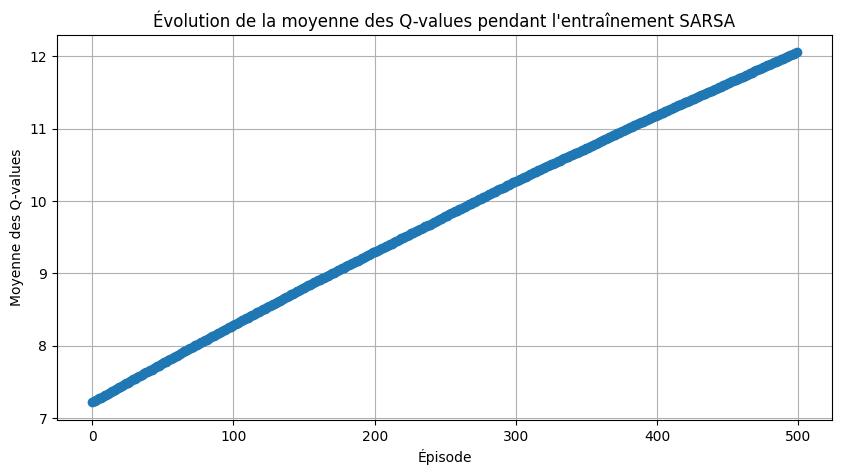

In [ ]:
plt.plot(clics_par_episode)
plt.title("SARSA avec affinité de genres")
plt.xlabel("Épisodes")
plt.ylabel("Clics pondérés")
plt.grid()
plt.show()


In [ ]:
# --- Recommandation pour chaque utilisateur ---
recommandations = {}

for user_id in user_to_idx:
    user_idx = user_to_idx[user_id]
    seen_ids = df[df['userId'] == user_id]['movieId'].map(movie_to_idx).dropna().astype(int).tolist()

    scores = q_table[user_idx].copy()
    scores[seen_ids] = -np.inf  # exclure les films vus

    top_idx = np.argmax(scores)
    movie_id = idx_to_movie[top_idx]
    title = idx_to_title.get(movie_id, "Inconnu")

    recommandations[user_id] = title



In [ ]:
# Exporter les recommandations
df_reco = pd.DataFrame(recommandations)
df_reco.to_csv("recommandations_sarsa.csv", index=False)

print("✅ Recommandations générées dans recommandations_sarsa.csv")

✅ Recommandations générées dans recommandations_sarsa.csv


In [ ]:
df_reco1 = pd.read_csv("recommandations_sarsa.csv")

In [ ]:
df_reco1.head(10)

,userId,movieId,title,score_Q
0,68,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.000
1,177,3578,Gladiator (2000),2.154
2,177,457,"Fugitive, The (1993)",1.207
3,177,2762,"Sixth Sense, The (1999)",0.729
4,177,2028,Saving Private Ryan (1998),0.669
5,177,4226,Memento (2000),0.024
6,182,588,Aladdin (1992),0.675
7,182,500,Mrs. Doubtfire (1993),0.488
8,182,344,Ace Ventura: Pet Detective (1994),0.000
9,182,364,"Lion King, The (1994)",0.000
